# Solving Sod Problem with PINN-WE


* This code is modified from the code https://github.com/alexpapados/Physics-Informed-Deep-Learning-Solid-and-Fluid-Mechanics

* The paper about this code can be reffed to https://www.researchgate.net/publication/359480166_Discontinuity_Computing_with_Physics-Informed_Neural_Network

* For strong shock waves, PINN-WE can let you get a discontinuous result quickly and sharply. But it can not guarantee the result must be physical. You can try to change the random seed or learning rate to get a different result. In the paper, we show the best result of some tests to demonstrate that PINN-WE has the potential ability to handle a non-linear discontinuous problem.

* So physics constraints are needed near shock waves. They are conservation laws, Rankine-Hugoniot relations and entropy condition. We develop a physics screen method here to determinate the problem.


In [1]:
def train(epoch):
    def closure():
        optimizer.zero_grad()                                                     
        loss_pde = model.loss_pde(x_int,x_screen2_L,x_screen2_R,0.01)                                    
        loss_ic = model.loss_ic(x_ic, rho_ic,u_ic,p_ic)   
        loss_bc = model.loss_ic(x_bc, rho_bc,u_bc,p_bc)   
        
        loss_rh1 = model.loss_rh(x_screen2,x_screen2_L,x_screen2_R) # RH relation
        loss_s0 = model.loss_character(x_screen2,x_screen2_R) # Entropy condition
       # loss_con3 = model.loss_con(x_screen3 ,x_ic,T3) #Conservation laws
        loss_con1 = model.loss_con(x_screen1 ,x_ic,T1) #Conservation laws
        loss = loss_pde + 10*(loss_ic+loss_bc) +  10*(loss_rh1 +loss_con1  )   +10* loss_s0  
       # print(f'epoch {epoch} loss_pde:{loss_pde:.8f},loss_rh1:{loss_rh1:.8f},loss_con:{loss_con1:.8f}, loss_s:{loss_s0:.8f}, loss_ic:{loss_ic:.8f}')
        loss.backward()
        return loss
    loss = optimizer.step(closure)
    return loss

In [160]:
3.528*0.13/0.5
(0.445,0.31061,8.928) for x ≤0, (ρ, m, E ) = (0.5,0,0.571)

0.91728

In [186]:
(8.928-0.445/2*(0.31061/0.445)**2)*0.4

3.527838844

In [16]:
import torch
import torch.nn as nn
import numpy as np
import time
import scipy.io
# Seeds
crhoL = 27/7
cuL = 2.629369
cpL = 31/3

crhoR = 1
cuR = 0
cpR = 1

#crhoL = 0.89
#cuL = 0.098923
#cpL = 1
#
#crhoR = 1
#cuR = 0
#cpR = 0.16185
#
#Ts = 0
#Te = 0.91728

Ts = 0
Te = 0.18
Xs = 0
Xe = 1
def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True

setup_seed(5)
   
def gradients(outputs, inputs):
    return torch.autograd.grad(outputs, inputs,grad_outputs=torch.ones_like(outputs), create_graph=True)

# Convert torch tensor into np.array
def to_numpy(input):
    if isinstance(input, torch.Tensor):
        return input.detach().cpu().numpy()
    elif isinstance(input, np.ndarray):
        return input
    else:
        raise TypeError('Unknown type of input, expected torch.Tensor or ' \
                        'np.ndarray, but got {}'.format(type(input)))

# Initial conditions
def IC(x):
    N = x.shape[0]
    rho_init = np.zeros((x.shape[0]))                                              
    u_init = np.zeros((x.shape[0]))                                                
    p_init = np.zeros((x.shape[0]))                                                

    # rho, p - initial condition
    for i in range(N):
        if (x[i,1] <= 0.2):
            rho_init[i] = crhoL
            u_init[i] = cuL
            p_init[i] = cpL
        else:
            rho_init[i] = crhoR*np.sin(50)
            u_init[i] = cuR
            p_init[i] = cpR

    return rho_init, u_init, p_init

def BC(x):
    N = x.shape[0]
    rho_init = np.zeros((x.shape[0]))                                              
    u_init = np.zeros((x.shape[0]))                                                
    p_init = np.zeros((x.shape[0]))                                                

    # rho, p - initial condition
    for i in range(N):
        if (x[i,1] <= 0.2):
            rho_init[i] = crhoL
            u_init[i] = cuL
            p_init[i] = cpL
        else:
            rho_init[i] = crhoR*np.sin(50)
            u_init[i] = cuR
            p_init[i] = cpR

    return rho_init, u_init, p_init


# Generate Neural Network
class DNN(nn.Module):

    def __init__(self):
        super(DNN, self).__init__()
        self.net = nn.Sequential()                                                  
        self.net.add_module('Linear_layer_1', nn.Linear(2, 30))                     
        self.net.add_module('Tanh_layer_1', nn.Tanh())                              

        for num in range(2, 7):                                                     
            self.net.add_module('Linear_layer_%d' % (num), nn.Linear(30, 30))       
            self.net.add_module('Tanh_layer_%d' % (num), nn.Tanh())                 
        self.net.add_module('Linear_layer_final', nn.Linear(30, 3))                 

    # Forward Feed
    def forward(self, x):
        return self.net(x)

    # Loss function for PDE
    def loss_pde(self, x,xL,xR,Dx):
        y = self.net(x)                                                
        rho,p,u = y[:, 0:1], y[:, 1:2], y[:, 2:]
        
        yR = self.net(xR)                                                
        rhoR,pR,uR = yR[:, 0:1], yR[:, 1:2], yR[:, 2:]
        yL = self.net(xL)                                                
        rhoL,pL,uL = yL[:, 0:1], yL[:, 1:2], yL[:, 2:]
        
        U2 = rho*u
        U3 = 0.5*rho*u**2 + p/0.4
        
        #F1 = U2
        F2 = rho*u**2+p
        F3 = u*(U3 + p)
        
        gamma = 1.4                                                    

        # Gradients and partial derivatives
        drho_g = gradients(rho, x)[0]                                  
        rho_t, rho_x = drho_g[:, :1], drho_g[:, 1:]             


        du_g = gradients(u, x)[0]                                      
        u_t, u_x = du_g[:, :1], du_g[:, 1:]                            
        
        dp_g = gradients(p, x)[0]                                      
        p_t, p_x = dp_g[:, :1], dp_g[:, 1:]                            

       # dp_g = gradients(p, x)[0]                                     
       # p_t, p_x = dp_g[:, :1], dp_g[:, 1:]                           
        
        dU2_g = gradients(U2, x)[0]
        U2_t,U2_x = dU2_g[:,:1], dU2_g[:,1:]
        dU3_g = gradients(U3, x)[0]
        U3_t,U3_x = dU3_g[:,:1], dU3_g[:,1:]
        dF2_g = gradients(F2, x)[0]
        F2_t,F2_x = dF2_g[:,:1], dF2_g[:,1:]
        dF3_g = gradients(F3, x)[0]
        F3_t,F3_x = dF3_g[:,:1], dF3_g[:,1:]

        #d = 0.05*(abs(u_x)-(u_x) + abs(rho_x)*(torch.sign(0.1-abs(u_x))+1))  + 1
        d = 0.2*(abs(u_x)-(u_x))  + 1
        
        #d = 0.1*(abs(uR-uL)-(uR-uL))/Dx + 1
        #d = torch.exp(-10*u_x)+1
        #d1 = torch.clamp(d/5,min=1)
     
        f = (((rho_t + U2_x)/d)**2).mean() + \
            (((U2_t  + F2_x)/d)**2).mean() + \
            (((U3_t  + F3_x)/d)**2).mean() #+\
            #((rho_t).mean())**2 +\
            #((U3_t).mean())**2 
    
        return f

    def loss_ic(self, x, rho, u, p):
        y = self.net(x)                                                      
        rho_nn, p_nn,u_nn = y[:, 0], y[:, 1], y[:, 2]            

        loss_ics = ((u_nn - u) ** 2).mean() + \
               ((rho_nn- rho) ** 2).mean()  + \
               ((p_nn - p) ** 2).mean()

        return loss_ics
    
    # Loss function for conservation
    def loss_con(self, x_en,x_in,t):
        y_en = self.net(x_en)                                       
        y_in = self.net(x_in)                                       
        rhoen, pen,uen = y_en[:, 0], y_en[:, 1], y_en[:, 2]         
        rhoin, pin,uin = y_in[:, 0], y_in[:, 1], y_in[:, 2]         

        U3en = 0.5*rhoen*uen**2 + pen/0.4
        U3in = 0.5*rhoin*uin**2 + pin/0.4
        gamma = 1.4
        cU3L = 0.5*crhoL*cuL**2 + cpL/0.4 
        cU3R = 0.5*crhoR*cuR**2 + cpR/0.4 
        # Loss function for the initial condition
        loss_en = ((rhoen - rhoin - t*(crhoL*cuL-crhoR*cuR)).mean())**2# + \
            #((U3en- U3in - t*(cU3L*cuL - cU3R*cuR)).mean())**2 +\
            #((-(cpL-cpR)*t + rhoen*uen - rhoin*uin).mean())**2
        return loss_en
    
    def loss_rh(self, x,x_l,x_r):
        y = self.net(x)                                    
        y_r = self.net(x_r)                                    
        y_l = self.net(x_l)                                    
        rho, p,u = y[:, 0], y[:, 1], y[:, 2]          
        rhol, pl,ul = y_l[:, 0], y_l[:, 1], y_l[:, 2]          
        rhor, pr,ur = y_r[:, 0], y_r[:, 1], y_r[:, 2]          

        du_g = gradients(u, x)[0]                                      
        u_t, u_x = du_g[:, :1], du_g[:, 1:]                            
        d = 1/(0.1*(abs(u_x)-u_x)  + 1)
        #eta =  torch.clamp(d-0.1,max=0)*torch.clamp(abs(p-pl)-0.01,min=0)*torch.clamp(abs(u-ul)-0.01,min=0)
        eta =  torch.clamp(abs(p-pl)-0.1,min=0)*torch.clamp(abs(u-ul)-0.1,min=0)
        #eta = 1
        
        #loss_rh =  (((rho/rhol - (6*p+pl)/(6*pl+p))*eta)**2).mean()+\
        loss_rh = (((rhor/rhol - (6*pr+pl)/(6*pl+pr))*(ur-ul)*eta)**2).mean()+\
                   ((((ur-ul)**2 -2/rhor*(pr-pl)**2/(0.4*pr+2.4*pl))*eta)**2).mean()
           #        ((((ur-u)**2 -2/rho*(pr-p)**2/(0.4*pr+2.4*p))*eta)**2).max()
            
        #loss_rh =  (((pr/pl - (6*rhor-rhol)/(6*rhol-rhor))*(pr-pl)*eta)**2).max()+\
                   #((((u-ul)**2 -2/rho*(p-pl)**2/(0.4*p+2.4*pl))*eta)**2).max()+\
        return loss_rh
    
    def loss_character(self, x_l,x_r):
        y_r = self.net(x_r)                                                      # Initial condition
        y_l = self.net(x_l)                                                      # Initial condition
        rhol, pl,ul = y_l[:, 0], y_l[:, 1], y_l[:, 2]            # rho, u, p - initial condition
        rhor, pr,ur = y_r[:, 0], y_r[:, 1], y_r[:, 2]            # rho, u, p - initial condition

        #du_g = gradients(ul, x_l)[0]                                      
        #u_t, u_x = du_g[:, :1], du_g[:, 1:]                            
        #d = 1/(0.1*(abs(u_x)-u_x)  + 1)
        #eta =  torch.clamp(d-0.1,max=0)*torch.clamp(abs(pr-pl)-0.01,min=0)*torch.clamp(abs(ur-ul)-0.01,min=0)
        eta =  torch.clamp(abs(pr-pl)-0.01,min=0)*torch.clamp(abs(ur-ul)-0.01,min=0)
       # eta = 1
        # Loss function for the initial condition
        gamma = 1.4
        ss = 1.0e-10
        cL = torch.sqrt(gamma*abs(pl)/(abs(rhol)+ss))
        cR = torch.sqrt(gamma*abs(pr)/(abs(rhor)+ss))
        sR = torch.max(ul+cL,ur+cR)* (rhol-rhor)
        sL = torch.min(ul-cL,ur-cR)*(rhol-rhor)
        
        s = rhol*ul - rhor*ur
       # if (s.max() > 1000):
       #     print(rhol-rhor)
       #     print(s)
        #print(torch.clamp(s-sR,min=0))
       # print(eta)
       # sm = exp(-100*(s-sR))
        loss_s = (((s-sR)*(s-sL)*eta)**2).mean()  #torch.min((((,torch.tensor(1.0))  #+ ((torch.clamp(sL-s,min=0))**2).max()
        return loss_s
        
    
def X_entropy(x,T,dt,dx):
    N=x.shape[0]
    xs   = np.zeros((N,2)) 
    xsL  = np.zeros((N,2)) 
    xsR  = np.zeros((N,2)) 
    xsP  = np.zeros((N,2)) 
    xsPL = np.zeros((N,2)) 
    xsPR = np.zeros((N,2)) 
    
    for i in range(N):
        xs[i,1] = x[i,1]
        xs[i,0] = x[i,0] + T
        xsL[i,1] = xs[i,1] - dx
        xsL[i,0] = xs[i,0]
        xsR[i,1] = xs[i,1] + dx
        xsR[i,0] = xs[i,0]
        xsP[i,0] = xs[i,0] + dt
        xsP[i,1] = xs[i,1]
        xsPL[i,0] = xsP[i,0]
        xsPL[i,1] = xsP[i,1]+ dx
        xsPR[i,0] = xsP[i,0]
        xsPR[i,1] = xsP[i,1]- dx
        
    return xs,xsL,xsR,xsP,xsPL,xsPR


def X_right(x,dx):
    N=x.shape[0]
    xen =np.zeros((N,2)) 
    
    for i in range(N):
        xen[i,1] = x[i,1] + dx
        xen[i,0] = x[i,0] 
    return xen
def bc_data(N,Ts,Te,Xs,Xe):
    x =np.zeros((2*N,2)) 
    
    for i in range(N):
        x[i,0] = (Te - Ts)*i/N
        x[i,1] = Xs
        
    for i in range(N):
        x[i+N,0] = (Te - Ts)*i/N
        x[i+N,1] = Xe
    return x
def Mesh_Data(num_x,num_t,Tstart,Tend, Xstart,Xend):
    x_ic = np.zeros((num_x,2))
    x_int = np.zeros((num_x*(num_t-1),2))
    
    x_bc =np.zeros((2*(num_t-1),2)) 
    
    dt = (Tend - Tstart)/num_t
    x =   np.linspace(Xs, Xe, num_x) 
    x_ic[:,0] = 0
    x_ic[:,1] = x
    t = np.linspace(Tstart+dt, Tend, num_t-1)                                     
    x_bc[:num_t-1,0] = t
    x_bc[:num_t-1,1] = Xstart 
    x_bc[num_t-1:,0] = t
    x_bc[num_t-1:,1] = Xend

    
    t_grid, x_grid = np.meshgrid(t, x)                                 
    T = t_grid.flatten()[:, None]                                      
    X = x_grid.flatten()[:, None]                                      
    x_int = X[:, 0][:,None]                                        
    t_int = T[:, 0][:,None]                                        

    x_int = np.hstack((t_int, x_int))                            
    
    return x_ic,x_bc,x_int
    
    
device = torch.device('cuda')         # change to cpu if you dont have a cuda device                              

Nx = 100
Nt = 200

x_ic,x_bc,x_int =  Mesh_Data(Nx,Nt,Ts,Te,Xs,Xe)
rho_ic, u_ic, p_ic= IC(x_ic)                    
rho_bc, u_bc, p_bc= BC(x_bc)                    

T1 = Te
T3 = Te
dx = 0.01
dt = 0.002
x_screen1,x_screen1_L,x_screen1_R,x_screen1_P,x_screen1_PL,x_screen1_PR = X_entropy(x_ic,T3,dt,dx)
x_screen2,x_screen2_L,x_screen2_R,x_screen2_P,x_screen2_PL,x_screen2_PR = X_entropy(x_int,0.0,dt,dx)
x_screen3,x_screen3_L,x_screen3_R,x_screen3_P,x_screen3_PL,x_screen3_PR = X_entropy(x_ic,T3,dt,dx)

x_screen1     = torch.tensor(x_screen1, requires_grad=True, dtype=torch.float32).to(device)
x_screen1_L   = torch.tensor(x_screen1_L, dtype=torch.float32).to(device) 
x_screen1_R   = torch.tensor(x_screen1_R, dtype=torch.float32).to(device)
x_screen1_P   = torch.tensor(x_screen1_P, requires_grad=True, dtype=torch.float32).to(device)
x_screen1_PL  = torch.tensor(x_screen1_PL, dtype=torch.float32).to(device)
x_screen1_PR  = torch.tensor(x_screen1_PR, dtype=torch.float32).to(device)

x_screen2     = torch.tensor(x_screen2, requires_grad=True, dtype=torch.float32).to(device)
x_screen2_L   = torch.tensor(x_screen2_L, dtype=torch.float32).to(device)
x_screen2_R   = torch.tensor(x_screen2_R, dtype=torch.float32).to(device)
x_screen2_P   = torch.tensor(x_screen2_P, requires_grad=True, dtype=torch.float32).to(device)
x_screen2_PL  = torch.tensor(x_screen2_PL, dtype=torch.float32).to(device)
x_screen2_PR  = torch.tensor(x_screen2_PR, dtype=torch.float32).to(device)

x_screen3     = torch.tensor(x_screen3, requires_grad=True, dtype=torch.float32).to(device)
x_screen3_L   = torch.tensor(x_screen3_L, dtype=torch.float32).to(device) 
x_screen3_R   = torch.tensor(x_screen3_R, dtype=torch.float32).to(device)
x_screen3_P   = torch.tensor(x_screen3_P, requires_grad=True, dtype=torch.float32).to(device)
x_screen3_PL  = torch.tensor(x_screen3_PL, dtype=torch.float32).to(device)
x_screen3_PR  = torch.tensor(x_screen3_PR, dtype=torch.float32).to(device)

x_ic = torch.tensor(x_ic,requires_grad=True, dtype=torch.float32).to(device)
x_bc = torch.tensor(x_bc,requires_grad=True, dtype=torch.float32).to(device)
x_int = torch.tensor(x_int, requires_grad=True, dtype=torch.float32).to(device)

rho_ic = torch.tensor(rho_ic, dtype=torch.float32).to(device)
u_ic = torch.tensor(u_ic, dtype=torch.float32).to(device)
p_ic = torch.tensor(p_ic, dtype=torch.float32).to(device)

rho_bc = torch.tensor(rho_bc, dtype=torch.float32).to(device)
u_bc = torch.tensor(u_bc, dtype=torch.float32).to(device)
p_bc = torch.tensor(p_bc, dtype=torch.float32).to(device)


model = DNN().to(device)

print('Start training...')


lr = 0.001                                                           # Learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

Start training...


In [17]:
np.shape(x_ic)

torch.Size([100, 2])

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

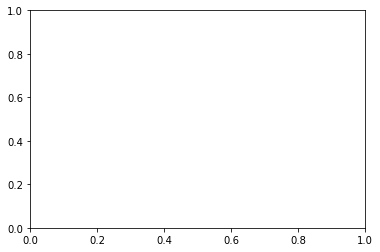

In [18]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.scatter(x_ic[:,0],x_ic[:,1])
ax.scatter(x_int[:,0],x_int[:,1])
ax.scatter(x_bc[:,0],x_bc[:,1])
#ax.set_ylim(0.0, 1.2)
plt.show()

In [19]:
y = self.net(x)                                                
rho,p,u = y[:, 0:1], y[:, 1:2], y[:, 2:]

yR = self.net(xR)                                                
rhoR,pR,uR = yR[:, 0:1], yR[:, 1:2], yR[:, 2:]
yL = self.net(xL)                                                
rhoL,pL,uL = yL[:, 0:1], yL[:, 1:2], yL[:, 2:]


    #((rho_t).mean())**2 +\
            #((U3_t).mean())**2 

NameError: name 'self' is not defined

In [20]:
epoch = 0
epochi = epoch
lr = 0.001                                                           # Learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
epochs = 100000
loss_history=[]
tic = time.time()
for epoch in range(1+epochi, epochs+epochi):
    loss = train(epoch)
    print(f'loss_tot:{loss:.8f}')
    loss_history.append(to_numpy(loss))
    if loss < 0.1:
        break
toc = time.time()
print(f'Total training time: {toc - tic}')


loss_tot:931.18554688
loss_tot:926.27392578
loss_tot:921.38000488
loss_tot:916.43786621
loss_tot:911.37976074
loss_tot:906.14990234
loss_tot:900.69494629
loss_tot:894.96301270
loss_tot:888.90557861
loss_tot:882.47772217
loss_tot:875.63690186
loss_tot:868.34161377
loss_tot:860.55377197
loss_tot:852.23986816
loss_tot:843.37359619
loss_tot:833.93878174
loss_tot:823.93060303
loss_tot:813.35766602
loss_tot:802.24353027
loss_tot:790.62847900
loss_tot:778.56878662
loss_tot:766.13769531
loss_tot:753.42425537
loss_tot:740.53039551
loss_tot:727.56817627
loss_tot:714.65429688
loss_tot:701.90502930
loss_tot:689.43066406
loss_tot:677.33032227
loss_tot:665.68823242
loss_tot:654.57153320
loss_tot:644.02990723
loss_tot:634.09674072
loss_tot:624.79028320
loss_tot:616.11645508
loss_tot:608.07098389
loss_tot:600.64184570
loss_tot:593.81085205
loss_tot:587.55554199
loss_tot:581.85015869
loss_tot:576.66723633
loss_tot:571.97729492
loss_tot:567.75024414
loss_tot:563.95526123
loss_tot:560.56164551
loss_tot:5

KeyboardInterrupt: 

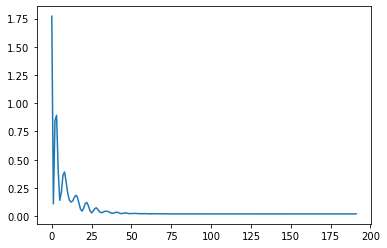

In [735]:
plt.plot(loss_Adam)

In [37]:
optimizer = torch.optim.LBFGS(model.parameters(),lr=0.01,max_iter=30)
epochi = epoch

epochs = 2000
tic = time.time()
for epoch in range(epochi, epochs+epochi):
    loss = train(epoch)
    print(f'loss_tot:{loss:.8f}')
    loss_history.append(loss)
toc = time.time()
print(f'Total training time: {toc - tic}')

loss_tot:0.46523267
loss_tot:0.33440477
loss_tot:0.33127862
loss_tot:0.32880950
loss_tot:0.32679051
loss_tot:0.32495359
loss_tot:0.31221938
loss_tot:0.31012586
loss_tot:0.31670964
loss_tot:0.30587462
loss_tot:0.30438152
loss_tot:0.30193749
loss_tot:0.29901445
loss_tot:0.29564247
loss_tot:0.29468393
loss_tot:0.29377526
loss_tot:0.29299715
loss_tot:0.29203850
loss_tot:0.28974634
loss_tot:0.28628024
loss_tot:0.28243402
loss_tot:0.27887323
loss_tot:0.27612865
loss_tot:0.27373758
loss_tot:0.27171031
loss_tot:0.26961997
loss_tot:0.26716602
loss_tot:0.26495516
loss_tot:0.26269475
loss_tot:0.26002285
loss_tot:0.25753701
loss_tot:0.25551254
loss_tot:0.25393617
loss_tot:0.25214836
loss_tot:0.25037229
loss_tot:0.24832465
loss_tot:0.24542353
loss_tot:0.24257244
loss_tot:0.24011694
loss_tot:0.23777539
loss_tot:0.23554902
loss_tot:0.23370443
loss_tot:0.23208745
loss_tot:0.23084663
loss_tot:0.22994047
loss_tot:0.22915781
loss_tot:0.22777377
loss_tot:0.22495463
loss_tot:0.22160779
loss_tot:0.21914640


KeyboardInterrupt: 

In [38]:
x = np.linspace(0.0, 1.0, 50)                                   
t = np.linspace(0.13, 0.13, 1)                                     
t_grid, x_grid = np.meshgrid(t, x)                               
T = t_grid.flatten()[:, None]                                    
X = x_grid.flatten()[:, None]                                    
x_test = np.hstack((T, X))                                       
x_1,xL,xR,xP,xPL,xPR = X_entropy(x_test,0.00,0.01,0.01)
x_test = torch.tensor(x_test, requires_grad=True, dtype=torch.float32).to(device)
xR = torch.tensor(xR, dtype=torch.float32).to(device)
xL = torch.tensor(xL, dtype=torch.float32).to(device)
u_pred = model(x_test)
uL_pred = model(xL)
uR_pred = model(xR)
rho, p,u = u_pred[:, 0], u_pred[:, 1], u_pred[:, 2]          
rhoL, pL,uL = uL_pred[:, 0], uL_pred[:, 1], uL_pred[:, 2]          
rhoR, pR,uR = uR_pred[:, 0], uR_pred[:, 1], uR_pred[:, 2]          
U2 = rho*u
U3 = 0.5*rho*u**2 + p/0.4

#F1 = U2
F2 = rho*u**2+p
F3 = u*(U3 + p)

gamma = 1.4                                                    

# Gradients and partial derivatives
drho_g = gradients(rho, x_test)[0]                                  
rho_t, rho_x = drho_g[:, :1], drho_g[:, 1:]             


du_g = gradients(u, x_test)[0]                                      
u_t, u_x = du_g[:, :1], du_g[:, 1:]                            

dp_g = gradients(p, x_test)[0]                                      
p_t, p_x = dp_g[:, :1], dp_g[:, 1:]                            

dp_g = gradients(p, x_test)[0]                                     
p_t, p_x = dp_g[:, :1], dp_g[:, 1:]                           

dU2_g = gradients(U2, x_test)[0]
U2_t,U2_x = dU2_g[:,:1], dU2_g[:,1:]
dU3_g = gradients(U3, x_test)[0]
U3_t,U3_x = dU3_g[:,:1], dU3_g[:,1:]
dF2_g = gradients(F2, x_test)[0]
F2_t,F2_x = dF2_g[:,:1], dF2_g[:,1:]
dF3_g = gradients(F3, x_test)[0]
F3_t,F3_x = dF3_g[:,:1], dF3_g[:,1:]

d = 0.1*(abs(u_x)-(u_x))  + 1

#d = 0.1*(abs(uR-uL)-(uR-uL))/Dx + 1
#d = torch.exp(-10*u_x)+1
#d1 = torch.clamp(d/5,min=1)

f = ((rho_t + U2_x)/d)**2 + \
    ((U2_t  + F2_x)/d)**2 + \
    ((U3_t  + F3_x)/d)**2 #+\
#d = 1/(0.1*(torch.clamp((abs(u_x)-u_x))
d = 1/(0.1*(abs(u_x)-u_x)+1)
d2 =1/(0.1*(abs(uR-uL)-(uR-uL))/0.02  + 1)
d = to_numpy(d)
d2 = to_numpy(d2)
f = to_numpy(f)
#d3 = to_numpy(d3)
u_pred = to_numpy(u_pred)
np.size(u_pred[:,0])

50

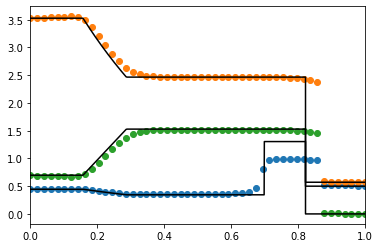

In [39]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.scatter(x[:],u_pred[:,0])
ax.scatter(x[:],u_pred[:,1])
ax.scatter(x[:],u_pred[:,2])
#ax.scatter(x[:],d2-1)
#ax.scatter(x[:],f)
ax.plot(Exact[:,0],Exact[:,1],color='black')
ax.plot(Exact[:,0],Exact[:,2],color='black')
ax.plot(Exact[:,0],Exact[:,3],color='black')
ax.set_xlim(0.0, 1.0)
plt.savefig('1.eps', format='eps')
#ax.set_ylim(0.0, 1.2)
plt.show()

In [ ]:
u_pred_i[:,:,k] = u_pred
k = k+1

In [295]:

u_pred_i = np.zeros((100,3,10))
k = 0

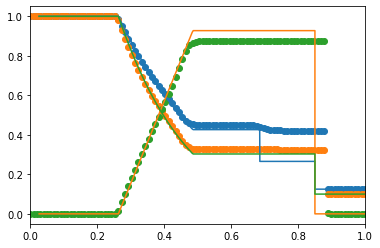

In [154]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.scatter(x[:],u_pred[:,0])
ax.scatter(x[:],u_pred[:,1])
ax.scatter(x[:],u_pred[:,2])
ax.plot(Exact[:,0],Exact[:,1])
ax.plot(Exact[:,0],Exact[:,2])
ax.plot(Exact[:,0],Exact[:,3])
ax.set_xlim(0.0, 1.0)
#ax.set_ylim(0.2, 1.2)
plt.show()

In [35]:
Exact = np.loadtxt('laxe.dat')
Exact[:,0]

array([-0.18472692, -0.1830151 , -0.18130328, ...,  1.13978891,
        1.14140047,  1.14301203])

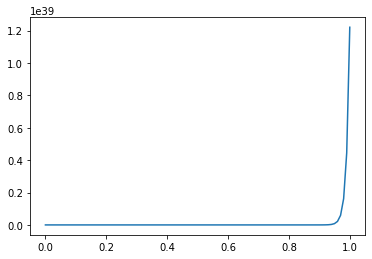

In [346]:
fig,ax = plt.subplots()
x = np.linspace(0,1,100)
#ax.plot(x,np.max([0.1-x,np.zeros_like(x)],axis=0))
#ax.plot(x,np.exp(100*(0.1-x))/ np.exp(100*(0.1)))
#ax.plot(x,np.exp(100*(-x)))
ax.plot(x,np.exp(100*(x-0.1)))
plt.show()

In [322]:
np.max([0.1-x,np.zeros_like(x)],axis=0)

array([0.1       , 0.08989899, 0.07979798, 0.06969697, 0.05959596,
       0.04949495, 0.03939394, 0.02929293, 0.01919192, 0.00909091,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [60]:
xp= x.flatten()[:,None]
rhop= u_pred[:,0].flatten()[:,None]
up= u_pred[:,1].flatten()[:,None]
pp= u_pred[:,2].flatten()[:,None]
uxy= np.hstack((xp,rhop,up,pp))    
np.savetxt('shockCrho.dat', uxy)

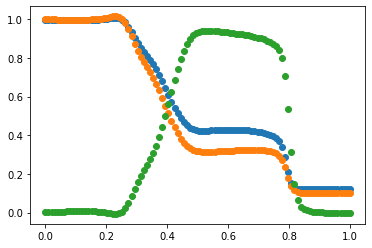

In [266]:
# first 15000step conservation
import matplotlib.pyplot as plt
plt.figure()
plt.scatter(x[:],u_pred[:,0])
plt.scatter(x[:],u_pred[:,1])
plt.scatter(x[:],u_pred[:,2])
plt.show()

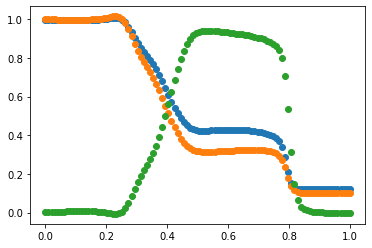

In [267]:
# first 15000step non-conservation
import matplotlib.pyplot as plt
plt.figure()
plt.scatter(x[:],u_pred[:,0])
plt.scatter(x[:],u_pred[:,1])
plt.scatter(x[:],u_pred[:,2])
plt.show()